# Parallélisation d'un algorithme de boosting

Jacques Song et Tristan Loisel, rendu le 03/02/2020 

Eléments logiciels pour traitement de données massives

Dans ce notebook, nous présentons un algorithme de boosting, codé en `python`, que nous parallélisons à l'aide du package `ray`.

## L'algorithme:

L'algorithme que nous implémentons est le suivant, il est largement inspiré par celui présenté par Aleksandar LAZAREVIC et Zoran OBRADOVIC dans *Boosting Algorithms for Parallel and Distributed Learning, Distributed and Parallel Databases, 11, 203–229, 2002*.


 Entrée: un set de données labellisées $S = \{(X_i,Y_i)\}_{i \in \{1,...,n\}}$, avec pour chaque $i$, $y_i \in \{0,...,9\}$

Initialisation: création d'une densité de probabilité sur S, $\mu_1$, telle que $\mu_1(i)=\frac{1}{n}$ pour chaque $i \in \{1,...,n\}$.

Pour chaque $t \in \{1,...,T\}$:

&nbsp;&nbsp;&nbsp;Pour chaque processeur $j \in \{1,...,J\}$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Tirer un échantillon à partir de la densité $\mu_t$
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Entraîner un classifieur $P_{t,j}$ en utilisant le processeur $j$
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Calculer une hypothèse $h_{t,j}$ de ce classifieur.
 
Créer l'hypothèse $h_t$ tel que: $h_t(i) = max\{h_{t,j}(i), j \in \{1,...,J\}\}$ associée au classifieur $P_{t}$

Calculer la perte de $P_t$: $\epsilon_t = \sum_{i = 1}^{n} \mu_t(i) (1 - h_t(x_i, y_i))$. C'est la moyenne pondérée par $\mu_t$ de $\mathbb{1}_{P_{t}(x_i) \neq y_i}$.

Calculer le confiance dans le classifieur $P_t$: $\beta_t = \frac{1}{2}\log\big(\frac{1 - \epsilon}{\epsilon} \big)$

Calculer $\mu_{t+1}(i) = \frac{\mu_{t}(i)}{C_t} e^{- \beta_t h_t(x_i, y_i)}$ où $C_t$ est une constante de normalisation.

Retourner $h = \text{argmax}_{y \in \{0,...,9\}} \sum_{t \in \{1,...,T\}} \beta_t h_t(.,y)$



L'algorithme implémenté diffère de celui du papier cité plus haut dans le calcul de la loss et la façon dont les poids sont mis à jour. En effet, nous avons repris le calcul d'AdaBoost pour la mise à jour des poids des données d'entraînement.

## Import des packages nécessaires

In [2]:
import ray
import time
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from sklearn import tree
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Construction des sets d'entraînement et de test

Nous avons choisi ici de travailler avec les données "mnist_784", qui contiennent des chiffres manuscrits. Nous nous limitons à un nombre restreint de données d'entraînement pour montrer l'efficacité des méthodes de boosting. En effet, ces dernières mettent l'accent sur les exemples mal classifiés à chaque itération, ainsi un faible nombre de données leur suffit (le dataset est artificiellement enrichi par le resampling à chaque itération).

In [3]:
X, y = fetch_openml(name="mnist_784", return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, random_state=0)

Nous montrons un échantillon du set d'entrainement

3


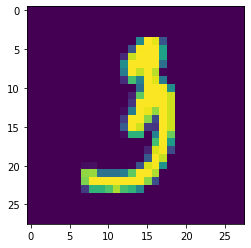

In [4]:
plt.imshow(np.reshape(X_train[0], (28, 28)))
print(y_train[0])

## Définition de quelques fonctions utiles

In [11]:
@ray.remote
def resample(probs, sample_size):
    """
    Performs resampling on the training set according to a probability distribution probs remotely using ray. 
    The resulting sample has size sample_size.
    """
    counts = np.random.multinomial(sample_size, probs)
    samples = []
    labels = []
    samples.append(sample(counts, X_train))
    labels.append(sample(counts, y_train))
    return samples, labels

def sample(counts, data):
    """
    Private function for helping the resample function.
    """
    sample = []
    for index, count in enumerate(counts):
        for _ in range(count):
            sample.append(data[index])
    return np.array(sample)

@ray.remote
def train_weak_learner(model, X_train, y_train):
    """
    Decorator to do the training on a remote node using ray.
    """
    model.fit(X_train, y_train)
    return model

@ray.remote
def make_hypothesis(model):
    """
    Decorator to generate a weak hypothesis. The hypothesis has confidence 1 in its prediction's class 
    and 0 in other classes
    """
    def fun(X, y):
        return int(model.predict([X])==y)
    return fun

def merge_hypothesis(hypotheses):
    """
    Creates strong hypothesis by selecting the most confident hypothesis. 
    In this case, any hypothesis with value 1 is selected.
    """
    def fun(X, y):
        return max([hypotheses[k](X, y) for k in range(P)])
    return fun

def make_final_classifier(hypothesis_list, betas_list):
    """
    Creates final classifier which selects the class with the highest confidence according to all strong hypotheses
    weighted by the confidence in each iteration.
    """
    def fun(X):
        temp_classes_score = []
        for y in classes:
            temp_it_score = []
            for t in range(T):
                temp_it_score.append(betas_list[t] * hypothesis_list[t](X, y))
            temp_classes_score.append(sum(temp_it_score))
        return str(np.argmax(temp_classes_score))
    return fun

def update_weights(D, beta, hypothesis):
    """
    Updates weights according to the performance of the strong hypothesis.
    """
    res = np.empty(shape=(N,), dtype=np.float32)
    index = 0
    for X, y in zip(X_train, y_train):
        res[index] = D[index] * np.exp(- beta * hypothesis(X, y))
        index += 1
    res = res / sum(res)
    return res

def error_pred_list(hypothesis):
    """
    Private function for computing the ada_loss.
    """
    res = []
    for i in range(N):
        res.append(1 - hypothesis(X_train[i], y_train[i]))
    return np.array(res)[:, np.newaxis]

def weighted_average(D, pred_list):
    """
    Helper function for computing weighted average.
    """
    return np.dot(D, pred_list)

def ada_loss(hypothesis, D):
    """
    Computes the AdaBoost loss of a given strong hypothesis weighted by a distribution D
    """
    return weighted_average(D, error_pred_list(hypothesis))

## Définition des paramètres

In [6]:
N = np.shape(X_train)[0]  # number of training examples
T = 10  # number of iterations
P = 10  # number of processors
depth = 4

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Implémentation de l'algorithme

Initialisation des différentes ressources.

In [7]:
ray.init(num_cpus=P)

2020-02-03 20:58:59,258	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-02-03 20:58:59,277	INFO resource_spec.py:212 -- Starting Ray with 3.56 GiB memory available for workers and up to 1.79 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-03 20:58:59,536	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.


{'node_ip_address': '192.168.1.12',
 'redis_address': '192.168.1.12:32078',
 'object_store_address': '/tmp/ray/session_2020-02-03_20-58-59_263639_47461/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-03_20-58-59_263639_47461/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-02-03_20-58-59_263639_47461'}

Initialisation uniformes des poids du jeu de données d'entraînement.

In [8]:
D = []
D.append(np.ones(shape=(N,), dtype=np.float32)/N)

### Entraînement

In [12]:
hypothesis_list = []
betas_list = []
for t in tqdm.trange(T):
    data_samples_id = []
    fitted_models_id = []  # list for storing the future fitted models
    hypotheses_id = []  # list for storing the future weak hypotheses
    weak_learners = [tree.DecisionTreeClassifier(max_depth=depth) for k in range(P)]  # list of weak learners
    for k in range(P):  # parallel sampling
        data_samples_id.append(resample.remote(D[-1], sample_size=N))
    data_samples = [ray.get(data_id) for data_id in data_samples_id]  # fetching the samples
    for k in range(P):
        # parallelize training of weak learner k
        model_id = train_weak_learner.remote(weak_learners[k], data_samples[k][0][0], data_samples[k][1][0])
        # add future fitted model id
        fitted_models_id.append(model_id)
        # add future hypothesis is
        hypotheses_id.append(make_hypothesis.remote(model_id))
        
    fitted_models = ray.get(fitted_models_id)  # get fitted weak learners
    weak_hypotheses_list = ray.get(hypotheses_id)  # get weak hypotheses
    hypothesis = merge_hypothesis(weak_hypotheses_list)  # compute strong hypothesis
    hypothesis_list.append(hypothesis)  # store strong hypothesis
    epsilon = ada_loss(hypothesis, D[-1])  # compute strong hypothesis loss
    if epsilon == 0:  # if no error, add epsilon to avoid division by zero
        print("No error")
        epsilon += 0.00001
    betas_list.append(.5 * np.log((1 - epsilon) / epsilon))  # compute and store beta
    D.append(update_weights(D[-1], betas_list[-1], hypothesis))  # update and store the new weights
    
final_classifier = make_final_classifier(hypothesis_list, betas_list)  # compute the final classifier

100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


## Résultats

### Performances du classifieur final

Regardons les performances du prédicteur final classe par classe. On commence par calculer les prédictions sur un échantillon du set de test.

In [13]:
res_final = []
for k in tqdm.trange(100):
    res_final.append(final_classifier(X_test[k]))
res_final = np.array(res_final)

100%|██████████| 100/100 [00:06<00:00, 16.75it/s]


On observe les prédictions par classe.

In [14]:
print(classification_report(y_test[:100], res_final))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83        14
           1       1.00      0.70      0.82        10
           2       0.44      0.67      0.53         6
           3       0.60      0.67      0.63         9
           4       0.85      0.94      0.89        18
           5       0.61      0.79      0.69        14
           6       0.80      0.67      0.73         6
           7       0.89      0.62      0.73        13
           8       0.50      0.60      0.55         5
           9       0.33      0.40      0.36         5

    accuracy                           0.72       100
   macro avg       0.70      0.68      0.68       100
weighted avg       0.76      0.72      0.73       100



## Intérêt de l'algorithme de boosting

Le boosting permet d'obtenir un classifieur performant, à partir d'un grand nombres de classifieurs élémentaires. Nous utilisons ici des arbres de décision de profondeur $4$, ce qui est une profondeur faible: un seul de ces arbres ne permet pas de prédir les labels avec précision. En revanche, le fait d'utiliser judicieusement plusieurs de ces arbres (ici en choisissant d'entraîner les nouveaux plus spécifiquement sur les données sur lesquelles les précédents ont échoué), permet d'obtenir un bon classifieur. 

Pour illustrer cette idée, nous avons calculé la précision du classifieur obtenu à partir des $t$ premiers arbres pour chaque $t \in \{1,...,T\}$: $h^t = \text{argmax}_{y \in \{0,...,9\}} \sum_{k \in \{1,...,t\}} \beta_k h_k(.,y)$

Comme le calcul de tous ces classifieurs est long, nous avons stocké les résultats dans les variables `accuracies_P_1` et `accuracies_P_8` ci-dessous (le code qui a été utilisé pour produire ces listes est très proche de celui du paragraphe "Entraînement" ci-dessus). `accuracies_P_1` a été calculée avec un seul processeur (`P=1`), et `accuracies_P_8` avec $8$ processeurs (`P=8`, sur un ordinateur à $8$ coeurs).

In [15]:
accuracies_P_1 = [0.1,0.53,0.53,0.6,0.65,0.672,0.688,0.71, 0.712, 0.716, 0.722, 0.722, 0.72, 0.722, 0.73, 0.734, 0.736, 0.752, 0.746, 0.744, 0.748, 0.742, 0.772, 0.772, 0.772,0.77, 0.77, 0.77, 0.772, 0.77]
accuracies_P_8 = [0.1, 0.43, 0.628, 0.676,0.7,0.726, 0.738, 0.762, 0.764, 0.778, 0.788, 0.806,0.81, 0.812, 0.81, 0.812, 0.822, 0.814, 0.822, 0.834,0.828, 0.832, 0.832, 0.814, 0.818, 0.828, 0.836, 0.83, 0.83, 0.832]

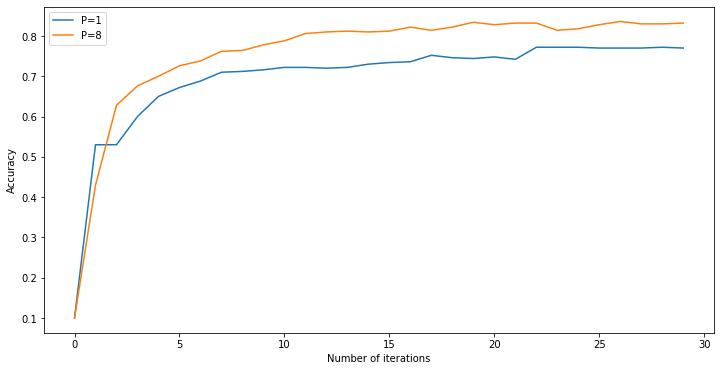

In [16]:
fig = plt.figure(1, figsize=(12, 6))
plt.plot(accuracies_P_1,label="P=1")
plt.plot(accuracies_P_8,label="P=8")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Nous observons bien qu'après une itération (i.e un seul arbre est utilisé), la précision est très faible. En revanche, après une vingtaine d'itérations, celle-ci devient raisonnable. Le classifieur devient donc de plus en plus performant au fur et à mesure des itérations, jusqu'à atteindre une précision limite.

On remarque également que l'utilisation de plusieurs processeurs en parallèle semble permettre d'atteindre une meilleure précision.

### Speed-up

On démontre ici le speed-up obtenu par parallélisation. On crée artificiellement des programmes d'entraînement et on observe les durées de calcul pour un nombre équivalent d'arbres de décision entraînés.

In [17]:
def parallel_training(P):
    weak_learners = [tree.DecisionTreeClassifier() for k in range(P)]
    fitted_models_id = []
    for k in range(P):
        # parallelize training of weak learner k
        model_id = train_weak_learner.remote(weak_learners[k], X_train, y_train)
        # add future fitted model id
        fitted_models_id.append(model_id)
    fitted_models = ray.get(fitted_models_id)
    return fitted_models

def sequential_training(P):
    weak_learners = [tree.DecisionTreeClassifier(max_depth=10) for k in range(P)]
    fitted_models = []
    for k in range(P):
        fitted_models.append(weak_learners[k].fit(X_train, y_train))
    return fitted_models

In [18]:
parallel_times = []
sequential_times = []

K = 20

for nbr_trees in tqdm.trange(1, K):
    start = time.time()
    parallel_fitted_models = parallel_training(10 * nbr_trees)
    end = time.time()
    parallel_times.append(end - start)

    start = time.time()
    sequential_fitted_models = sequential_training(10 * nbr_trees)
    end = time.time()
    sequential_times.append(end - start)


100%|██████████| 19/19 [03:40<00:00, 19.51s/it]


On regarde les durées d'exécutions en fonction du nombre d'arbre.

[]

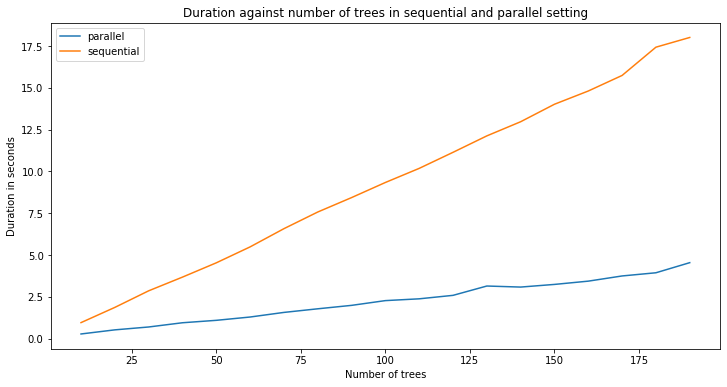

In [19]:
fig = plt.figure(1, figsize=(12, 6))
plt.plot(10 * np.arange(1, K), parallel_times, label='parallel')
plt.plot(10 * np.arange(1, K), sequential_times, label='sequential')
plt.xlabel("Number of trees")
plt.ylabel("Duration in seconds")
plt.title("Duration against number of trees in sequential and parallel setting")
plt.legend()
plt.plot()

On observe une dépendance linéaire logique dans les deux cas. La pente dans le cas parallélisé est plus faible comme attendu. On peut s'intéresser au *speed-up* pour voir lévolution du gain de temps de la parallélisation.

[]

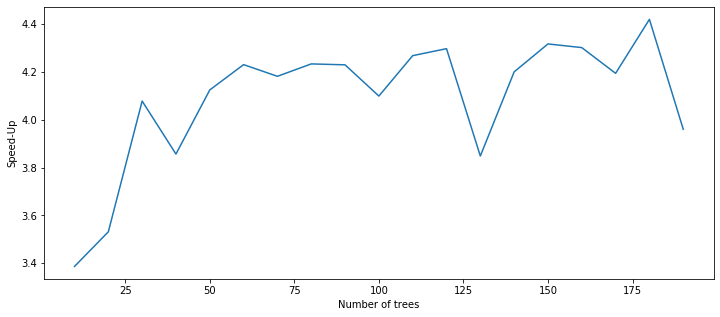

In [24]:
fig = plt.figure(1, figsize=(12, 5))
plt.plot(10 * np.arange(1, K), np.array(sequential_times) / np.array(parallel_times))
plt.xlabel("Number of trees")
plt.ylabel("Speed-Up")
plt.plot()

On observe un speed-up intéressant (aux alentours de 5 pour 10 CPUs sur un MacBook Pro 2018 avec un processeur aux specs suivantes : 2.2 GHz 6-Core Intel Core i7). Pour des méthodes ensemblistes, en particulier le boosting, la parallélisation permet un gain de temps important sur la phase d'entraînement des weak learners. Cela peut se révéler particulièrement intéressant pour des weak learners coûteux à entraîner comme des réseaux neuronaux. 